# Population genetics 1: deterministic discrete-time models

## [Models in Population Biology](http://modelspopbiol.yoavram.com)
## Yoav Ram

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('talk')

Today we focus on **discrete-time models**.
These models can follow, for example:

- The size of an insect population in year i;
- The proportion of individuals in a population carrying a particular gene in the i-th generation;
- The number of cells in a bacterial culture on day i;
- The concentration of a toxic gas in the lung after the i-th breath;
- The concentration of drug in the blood after the i-th dose.

We will model a population with two distinct **types**, focusing on the change in the frequency of individuals in each of these types from one time point to the next.
These types can model [colored balls](https://en.wikipedia.org/wiki/Polya_urn_model), genes, product, health vs. disease, or even technologies such as USB plug types.

Here, we will start with a simple deterministic one-dimensional model; in the next session we will develop a stochastic model that adds random sampling.

# Discrete-time univariate deterministic model: Haploid selection

We will consider a *vary large* population with two types, $A$ and $B$.
We'll think about these types as two genetic variants $A$ and $B$, for example, two types of bacteria, one that likes to eat glucose and one that prefers galactose.
Or we could think about ancient humans that can either be hunters or gatherers (assuming that this traits goes from father to son or from mother to daughter).

The assumption of a very large population means that we can use the *law of large numbers* to assume that noise or randomness have very little effect on the dynamics, hence we use a *deterministic* model.
The distinction will become clearer below when we consider a *stochastic* model.

An important concept in this model is **fitness**:

> Fitness is the reproductive success, composed of survival, mating success, fecundity etc. When a trait that affects fitness is heritable -- the offspring have the same trait as the parent -- then it will tend to increase in frequency.

We denote the fitness of $A$ relative to $B$ as $1+s$, hence $s$ is the relative advantage of $A$, or $A$'s *selection coefficient*.
This essentially means that *on average*, $A$ leaves $1+s$ more viable offspring compared to $B$.

We denote the frequency of $A$ and $B$ as $p$ and $1-p$ and write an equation that describes the frequency of $A$ in the next generation, $p'$:

$$
p' = \frac{p (1+s)}{p (1+s) + 1-p} \quad (1)
$$

where $\hat{w} = p (1+s) + 1-p$ is the **mean fitness** of the population.

This model is attributed to [Haldane 1924](link.springer.com/article/10.1007%2FBF02459574).

![Haldane](https://www.biografiasyvidas.com/biografia/h/fotos/haldane.jpg)

**[J.B.S. Haldane](https://en.wikipedia.org/wiki/J._B._S._Haldane), 1892-1964**

Let's write a function that iterates eq. 1 a specific number of generations.

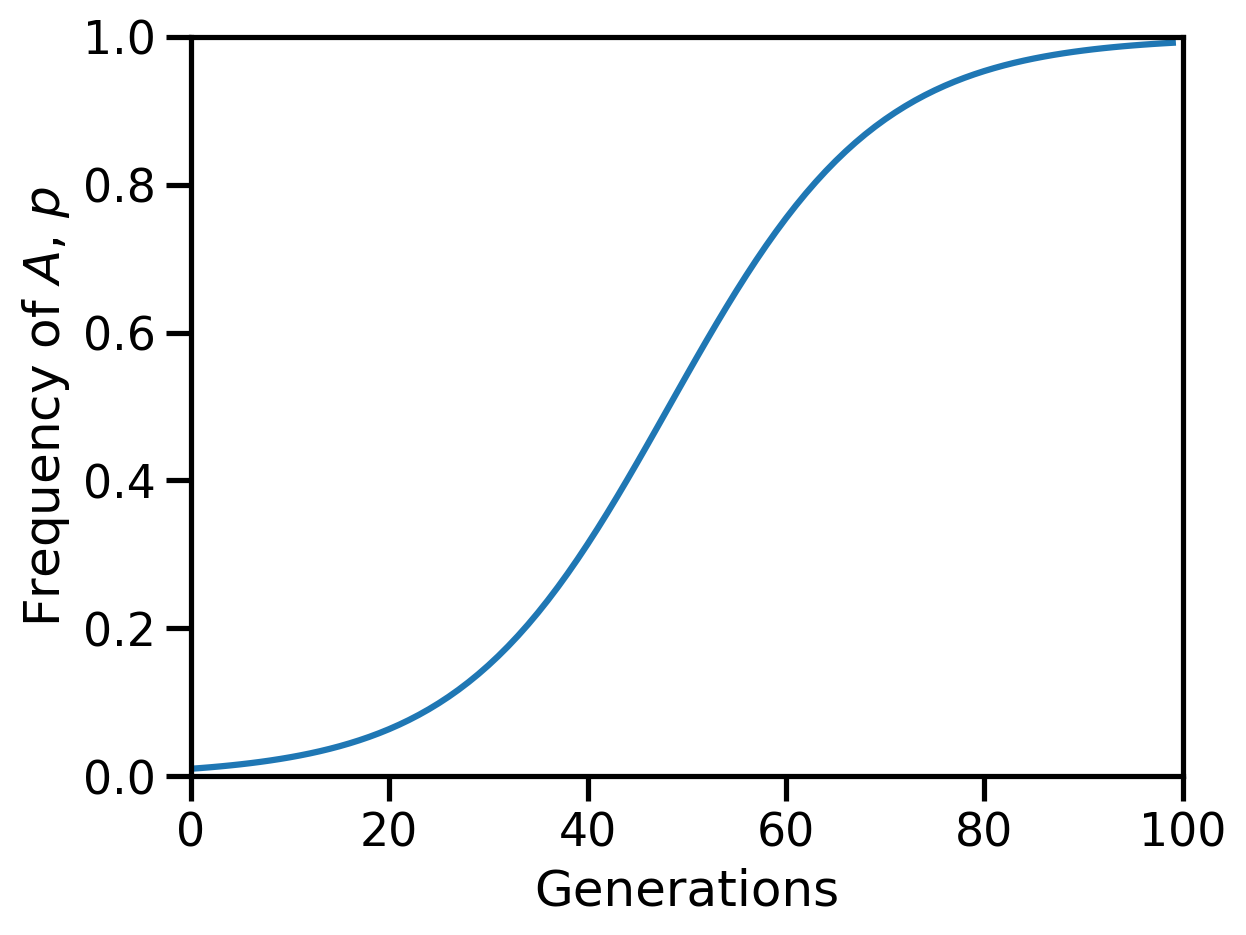

In [2]:
def haploid_selection(p0, s, tmax):
    p = [p0]

    for t in range(1, tmax):
        p_t = p[t-1] * (1 + s) / (1 + p[t-1] * s)
        p.append(p_t)

    return p

p = haploid_selection(0.01, 0.1, 100)
plt.plot(p)
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, len(p));

Let's see how fast evolution is for different strengths of selection $s$, i.e., advantages to $A$ over $B$.

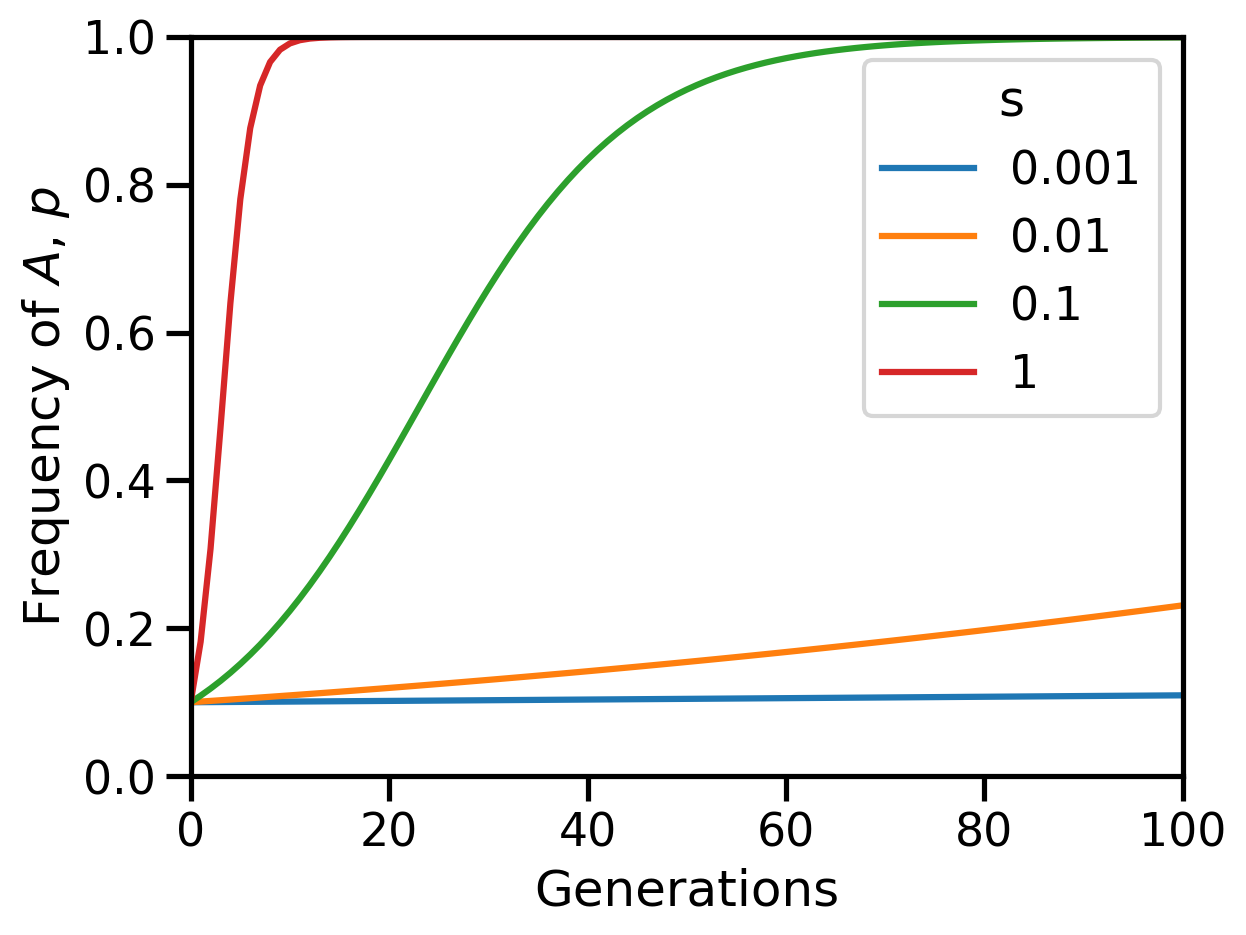

In [3]:
for s in (0.001, 0.01, 0.1, 1):
    plt.plot(haploid_selection(0.1, s, 100000), label=s)

plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, len(p))
plt.legend(title='s');

So the strength of selection has a hugh effect on the speed of evolution.

## Recurrence solution

The recurrence equation (1) can be solved so that we have an equation of $p_t=f\left(t,s,p_0\right)$ as a function of time (in generations), the selection coefficient $s$, and the initial frequency $p_0$.

Let's write the recurrence for $q_t=(1-p_t)$ the frequency of $B$ (it's a bit easier to solve that way):

$$
q_t = \frac{q_{t-1}}{q_t + (1-q_t)(1+s)} = 
\frac{q_{t-1}}{1-s(1-q_t)}
$$

If we write the formula for $q_1$ and $q_2$ we can get

$$
q_2 = \frac{q_0}{q_0 + (1-q_0)(1+s)^2}
$$

which hints at 

$$
q_t = \frac{q_0}{q_0 + (1-q_0)(1+s)^t}
$$

and quivalently

$$
p_t = 1 - \frac{1-p_0}{1-p_0 + p_0(1+s)^t} \quad (2)
$$


Let's check it numerically:

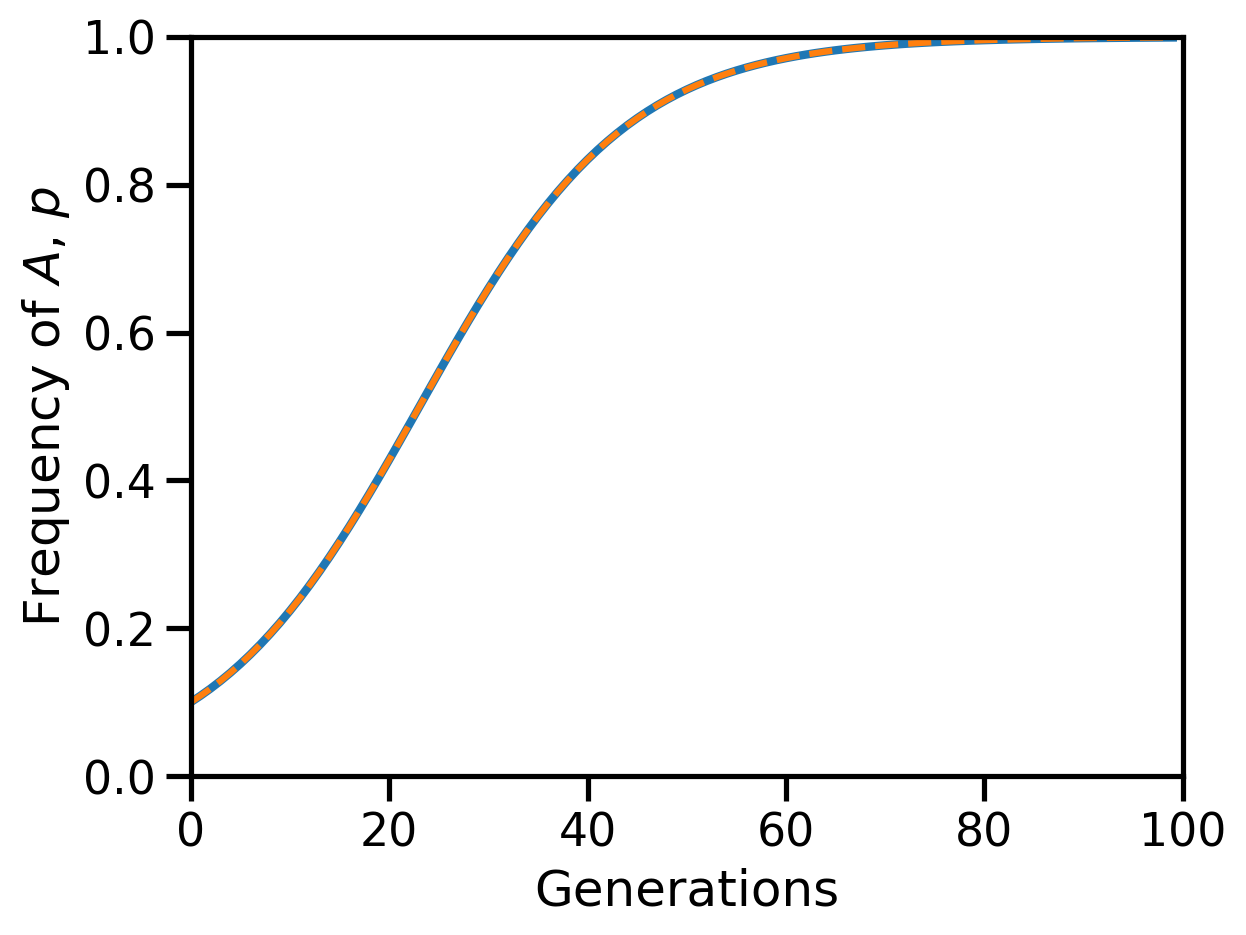

In [4]:
def haploid_selection_solution(p0, s, tmax):
    return [
        1 - (1-p0)/(1 - p0 + p0 * (1 + s)**t)
        for t in range(int(tmax))
    ]

plt.plot(haploid_selection(0.1, 0.1, 100), lw=3, label='recurrence')
plt.plot(haploid_selection_solution(0.1, 0.1, 100), '--', label='solution')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, len(p));

Looks good, so we can try and prove it using induction:

$$
q_{t+1} = \frac{q_t}{1+s(1-q_t)} = \\
\frac{\frac{q_0}{q_0 + (1-q_0)(1+s)^t}}{1+s\Big(1-\frac{q_0}{q_0 + (1-q_0)(1+s)^t}\Big)} = \\
\frac{\frac{q_0}{q_0 + (1-q_0)(1+s)^t}}{1+s-\frac{sq_0}{q_0 + (1-q_0)(1+s)^t}} = $$$$
\frac{q_0}{(1+s)(q_0 + (1-q_0)(1+s)^t) - sq_0} = \\
\frac{q_0}{q_0+s q_0 + (1-q_0)(1+s)(1+s)^{t}) - sq_0} = $$$$
\frac{q_0}{q_0 + (1-q_0)(1+s)^{t+1})}
$$

which proves the induction.

## Fixation time

Using the closed form solution in eq. 2, we can find the time for increase from some low frequency $p_0$ to a high frequency $1-p_0$, which will approximate the time it takes type $A$ to dominate the population when it is initially rare -- this is called the **fixation time**.

We need to solve the following for $t$:

$$
1-p_0 = 1-\frac{1-p_0}{1-p_0+p_0(1+s)^t} \Rightarrow $$$$
p_0 = \frac{1-p_0}{1-p_0+p_0(1+s)^t} \Rightarrow $$$$
(1+s)^t = \frac{(1-p_0)^2}{p_0^2}
$$

Taking the log of both sides

$$
t  = \frac{2\log{\left(\frac{1-p_0}{p_0}\right)} }{log (1+s)}
$$

If we assume that $p_0 \approx 0$ so $(1-p_0)/p_0 \approx 1/p_0$ then

$$
t  = \frac{-2\log{p_0}}{log (1+s)}
$$

Let's validate using the numericall iteration.

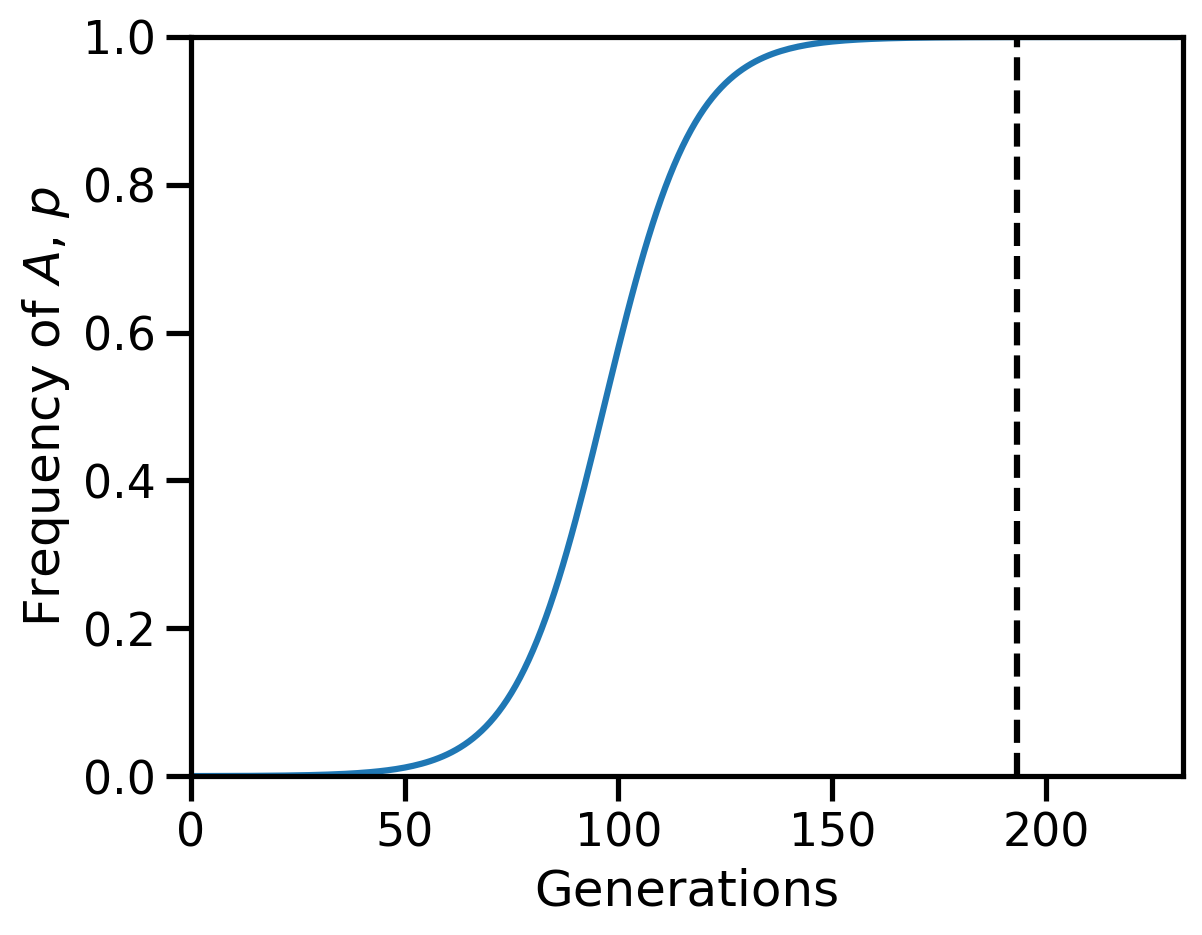

In [5]:
p0 = 1e-4
s = 0.1
t = -2 * np.log(p0) / np.log(1+s)

plt.plot(haploid_selection_solution(p0, s, 1.2*t), '-')
plt.axvline(t, ls='--', color='k')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, 1.2*t);

Of course, the assumption of a *very large population* breaks when either the population size is not very large, or when the population is very large but one of the type is extermely rare.
We'll come back to this later in the course.

# Discrete-time univariate deterministic model: Diploid selection

Let's set up a diploid version of the same model we had above:
- Alleles: $A_1$, $A_2$
- Allele frequencies: $p$, $q=1-p$
- Genotypes: $A_1 A_1$, $A_1 A_2$, $A_2 A_2$
- Genotype frequencies: $p^2$, $2pq$, $q^2$
- Fitness: $w_{11}=1$, $w_{12}=1-hs$, $w_{22}=1-s$
with $s>0$.

The latter are parameterizations of the action of selection, such that $s$ is the selection against $A_2$ and $h$ is the dominance of $A_1$ over $A_2$.

So, allele frequencies after viability selection are
$$
p' = \frac{p^2 + p q (1-hs)}{\bar{w}} $$$$
q' = \frac{q^2 (1-s) + p q (1-hs)}{\bar{w}} $$$$
\bar{w} = p^2 + 2 p q (1-hs) + q^2 (1-s)
$$

In [7]:
def diploid_selection(p0, s, h, tmax):
    p = [p0]

    for t in range(1, tmax):
        p_ = p[t-1]
        q_ = 1-p_
        
        wbar  = p_*p_ + 2*p_*q_*(1 - h*s) + q_*q_*(1-s)
        p_t = (p_*p_ + p_*q_*(1-h*s)) / wbar
        
        p.append(p_t)

    return p

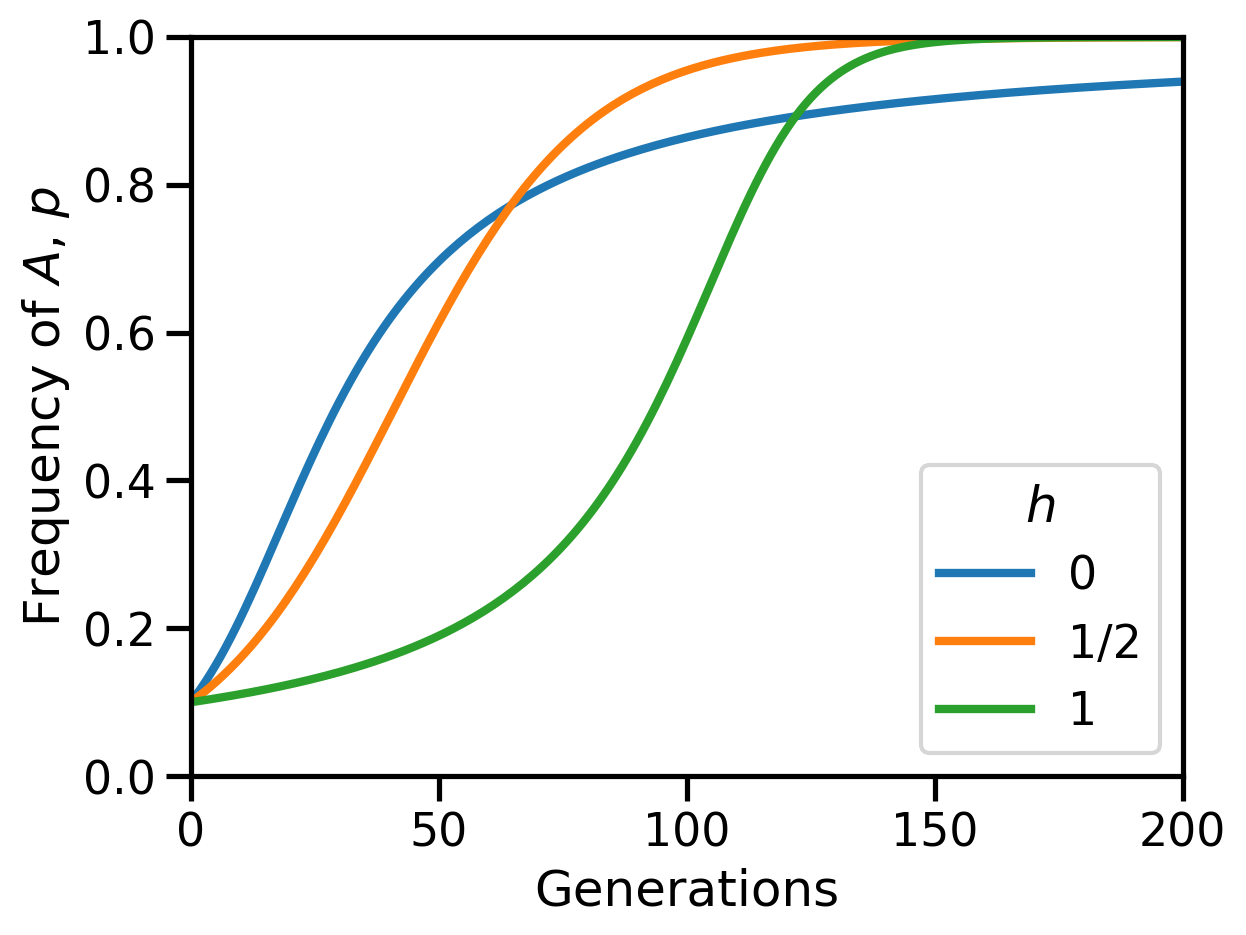

In [8]:
plt.plot(diploid_selection(0.1, 0.1, 0, 200), lw=3, label='0')
plt.plot(diploid_selection(0.1, 0.1, 0.5, 200), lw=3, label='1/2')
plt.plot(diploid_selection(0.1, 0.1, 1, 200), lw=3, label=1)
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.legend(title='$h$')
plt.ylim(0, 1)
plt.xlim(0, 200);

## Equilibria

First, we will examine the equilibria, or fixed points, of this system.

**Definition.**
$p^*$ is an *equilibrium* if it satisfies the equation $p'=p$.

### Fixation equilibria
Some of the equilibria are easy to find.
Setting $p=0$ in $p'$,
$$
0 = \frac{0}{w_3} = 0
$$

and setting $q=0 \; (p=1)$ in $q'$
$$
0 = \frac{0}{w_1} = 0
$$

**Result.**
Fixation of $A_2$ ($p=0$) and $A_1$ ($p=1$) are both equilibria.

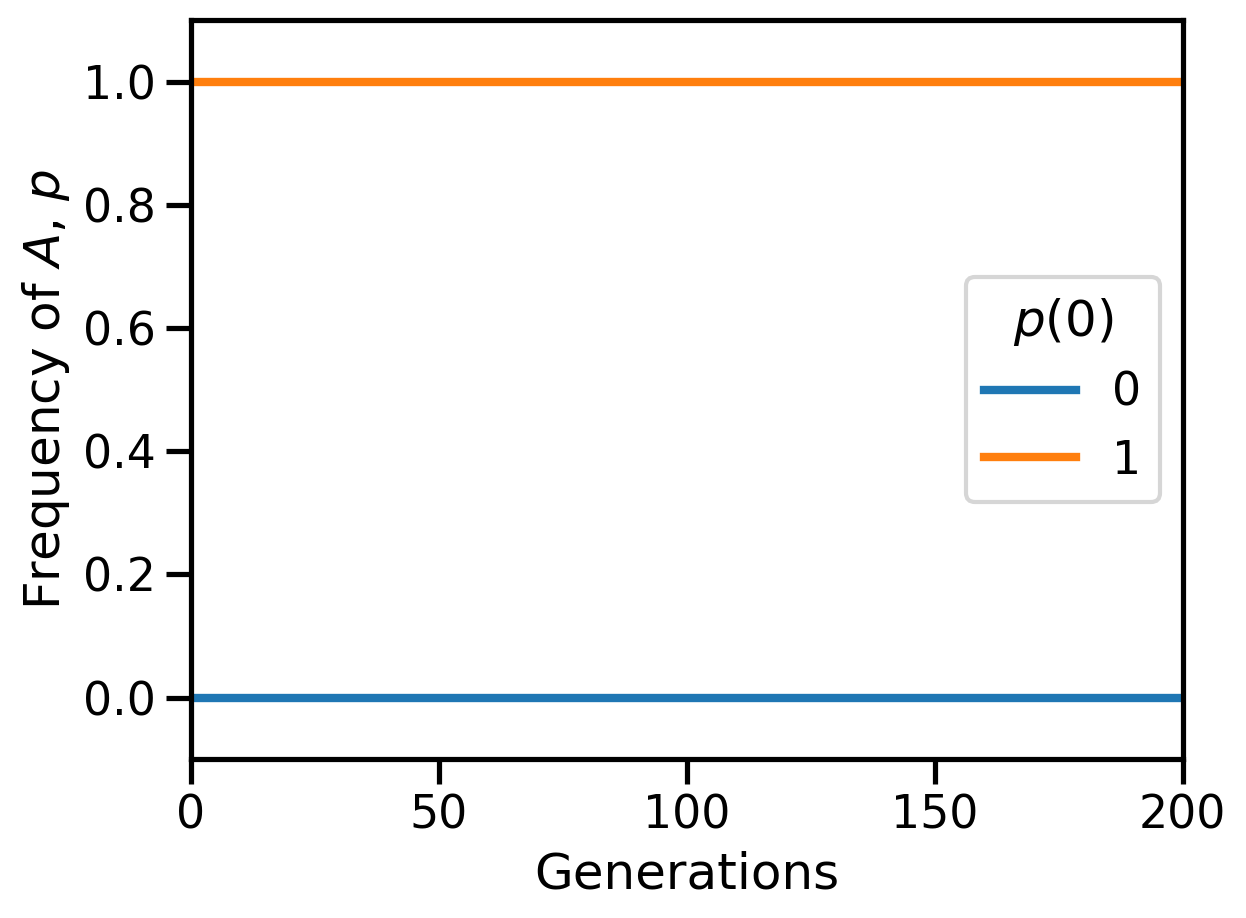

In [9]:
plt.plot(diploid_selection(0, 0.1, 0.5, 200), lw=3, label='0')
plt.plot(diploid_selection(1, 0.1, 0.5, 200), lw=3, label='1')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.legend(title='$p(0)$')
plt.ylim(-0.1, 1.1)
plt.xlim(0, 200);

### Polymorphic equilibria

**Definition.** *Polymorphism* is the the occurrence of more than one type or form in the same population, $0 < p < 1$.

Do we have a polymorphic equilibrium?
Let's solve for a general $p^*$.

First, we assume $p \ne 0$ (because that is not a polymorphic equilibrium) we can divide by $p$,
$$
p = \frac{p^2 w_1 + p q w_2}{p^2 w_1 + 2 p q w_2 + q^2 w_3} \Rightarrow $$$$
1 = \frac{p w_1 + q w_2}{p^2 w_1 + 2 p q w_2 + q^2 w_3} $$$$
p^2 w_1 + 2 p q w_2 + q^2 w_3 = p w_1 + q w_2 \Rightarrow $$$$
p^2 w_1 - p w_1 + 2 p q w_2 - q w_2 + q^2 w_3 = 0 \Rightarrow $$$$
-p(1-p) w_1 -(1-p)(1-2p) w_2 + (1-p)^2 w_3 = 0
$$

Second, we assume $p \ne 1$ (again that is not a polymorphic equilibrium), so we can divide by $1-p$:
$$
-p(1-p) w_1 -(1-p)(1-2p) w_2 + (1-p)^2 w_3 = 0 \Rightarrow $$$$
-p w_1 -(1-2p) w_2 + (1-p) w_3 = 0 \Rightarrow $$$$
-p w_1 -(1-2p) w_2 + (1-p) w_3 = 0 \Rightarrow $$$$
p (-w_1 +2 w_2 - w_3) - w_2 + w_3 = 0
$$

So we have
$$
p (-w_1 +2 w_2 - w_3) - w_2 + w_3 = 0 \Rightarrow $$$$
p (-1 +2 (1-hs) - 1 + s) - 1 + s + 1 - hs = 0 \Rightarrow $$$$
p s(1-2h) + s(1-h) = 0 \Rightarrow $$$$
p^* = \frac{h-1}{2h-1}
$$
So we have the following result.

**Result.**
If a polymorphic equilibrium exists, it is $p^* = \frac{h-1}{2h-1}$.

Note that $p^*$ is a frequency so it must satisfy
$0 < \frac{h-1}{2h-1} < 1$.

Now, $s>0$ and if we check for $h$ we find that this occurs only if $h<0$ or $h>1$.

**Result.**
When $h < 0$ or $1 < h$, a polymorphic equilibrium exists.
When $0 \le h \le 1$, a polymorphic equilibrium cannot exist.

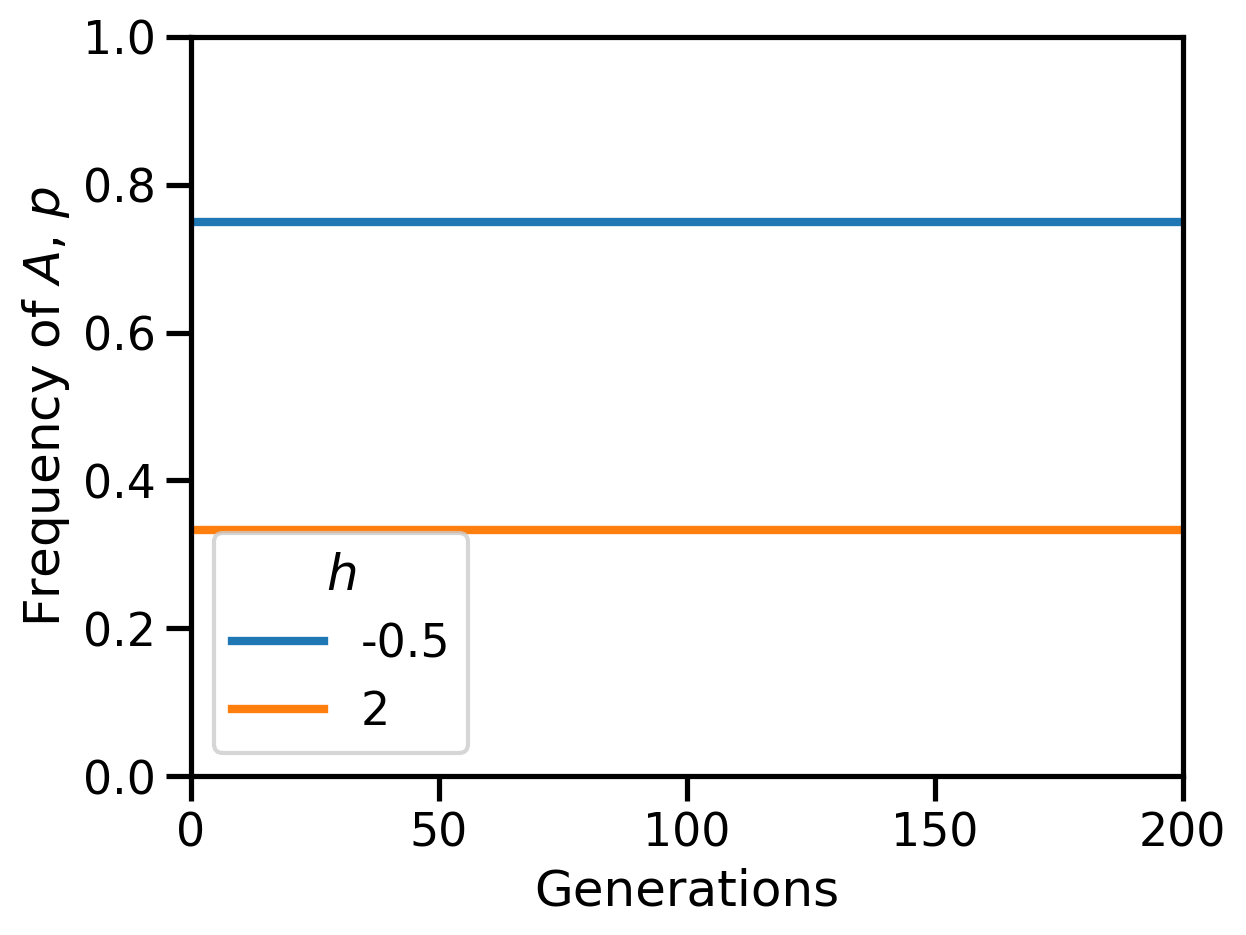

In [10]:
h = -1/2
p = diploid_selection((h-1)/(2*h-1), 0.1, h, 200)
plt.plot(p, lw=3, label=h)

h = 2
p = diploid_selection((h-1)/(2*h-1), 0.1, h, 200)
plt.plot(p, lw=3, label=h)

plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.legend(title='$h$')
plt.ylim(0, 1)
plt.xlim(0, 200);

## Local stability

**Definition.** *Local stability* indicates that a system is stable over small disturbances.
Formally, an equilibrium $p^*$ is locally stable if there exists $\delta>0$ such that for any $p$ with $| p-p^* | < \delta$ we have
$$
|p' - p^*| < |p - p^*|
$$ 

We'll check for local stability of $p=0$ and $p=1$.

Denote the transformation $p'=F(p)=\frac{f(p)}{\bar{w}(p)}$ such that
$$
f(p)=p^2 + p(1-p) (1-hs), $$$$
\bar{w}(p)= p^2 +2pq (1-hs) + q^2 (1-s)
$$

This transformation can be approximated by a linear function (Taylor expansion) around a given point $p_0$ by
$$
p' = F(p) = F(p_0) + (p-p_0)F'(p) + o((p-p_0)^2)
$$

The derivative of the transformation $F(p)$ is
$$
F'(p) = \frac{f'(p) \bar{w}(p) - f(p) \bar{w}'(p)}{\bar{w}^2(p)}
$$
with
$f'(p) = 2p + (1-2p) (1-hs)$.
and we don't need to worry about $\bar{w}'(p)$, as you will see next.

Set $p_0=0$ for fixation of $A_2$ and $p \approx 0$, that is, $o(p^2)=0$ (this is the small-o notation, which means that $p^2$ is very close to zero).
Then, with $F(0)=0$, $f'(0) = 2 \cdot 0 \cdot 1 + (1-2\cdot0) (1-hs)$, and $f(0)=0$ we get
$$
p' = F(p) = F(0) + p F'(0) + o(p^2) = $$$$
p\frac{f'(0) \bar{w}(0) - f(0) \bar{w}'(0)}{\bar{w}^2(0)} + o(p^2) = 
p\frac{1-hs}{1-s} + o(p^2)
$$

Therefore, disregarding terms of order $p^2$ (due to the small-o),
$$
\frac{p'}{p} = \frac{1-hs}{1-s}
$$

For stability of $p=0$ we require $\frac{p'}{p} < 1$.
Since $0 < s < 1$,
$$
\frac{1-hs}{1-s} < 1 \Rightarrow 
1-hs < 1-s \Rightarrow  $$$$
-hs < -s \Rightarrow 
h > 1
$$

Similarly, let $g(q) = q^2 (1-s) + q(1-q) (1-hs)$ with $g'(q) = 2q (1-s) + (1-2q) (1-hs)$ and set $q_0=0$ for fixation of $A_1$, so 
$$
q' = \frac{g(0) + (q - 0) g'(0) + o(q^2)}{\bar{w}(0)} \Rightarrow $$$$
q' = q \frac{1-hs}{1} + o(q^2)
$$

So, for $q \approx 0$ we have
$$
\frac{q'}{q} = \frac{1-hs}{1} = 1-hs
$$

Therefore, for stability of $q=0$ ($p=1$) we require 
$$
1-hs < 1 \Rightarrow $$$$
-hs < 0 \Rightarrow $$$$
h > 0
$$

**Result.**
Fixation of $A_1$ ($p=1$) is locally stable when $h>0$.

Fixation of $A_2$ ($p=0$) is locally stable when $h>1$.

**Definition.**
When both fixations are unstable, that is $h<0$, we have a *protected polymorphism*.

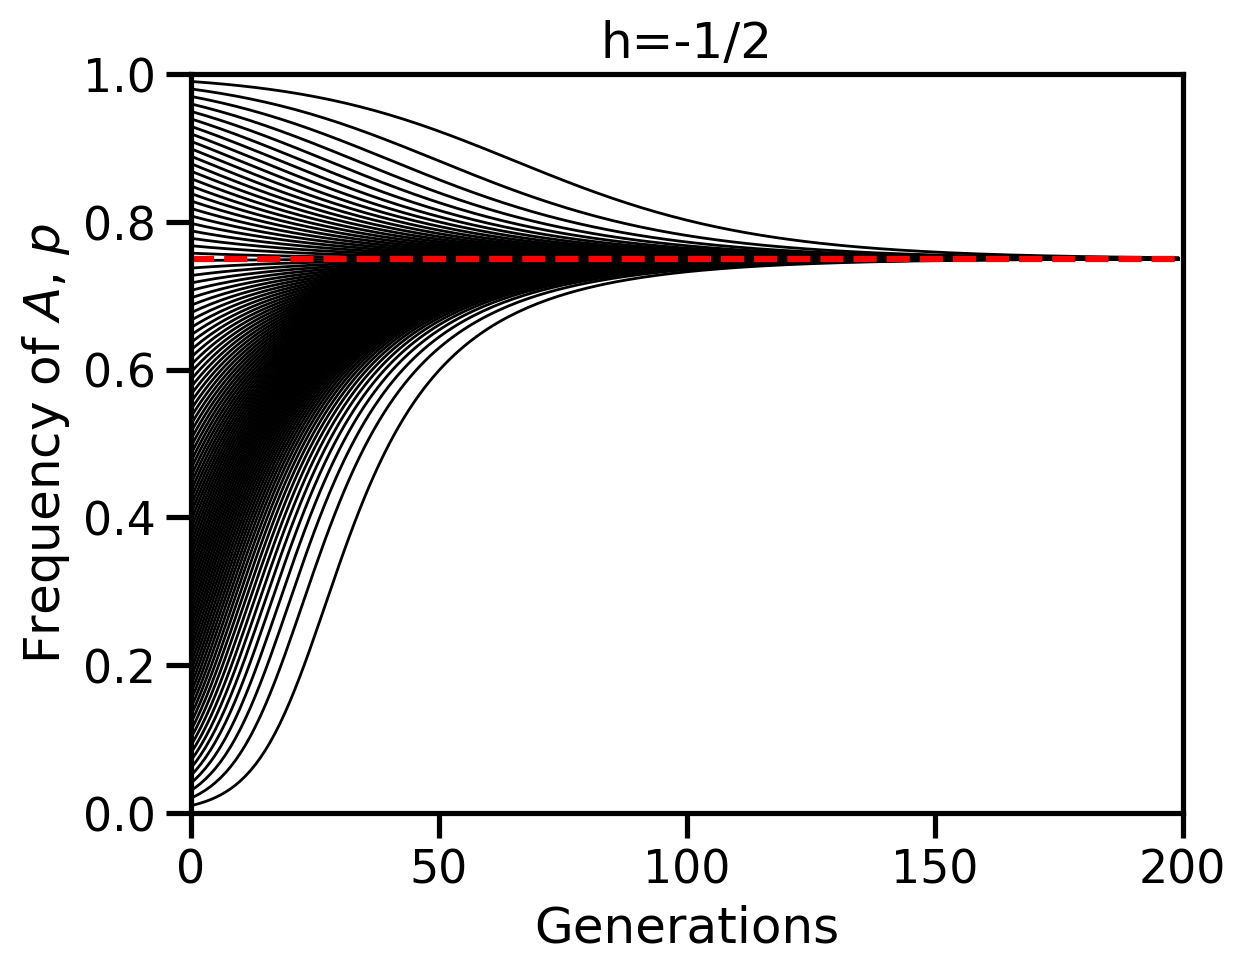

In [11]:
h = -1/2
for p0 in np.linspace(0, 1, 100):
    p = diploid_selection(p0, 0.1, h, 200)
    plt.plot(p, 'k', lw=1)

plt.axhline((h-1)/(2*h-1), ls='--', color='r')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, 200)
plt.title('h=-1/2');

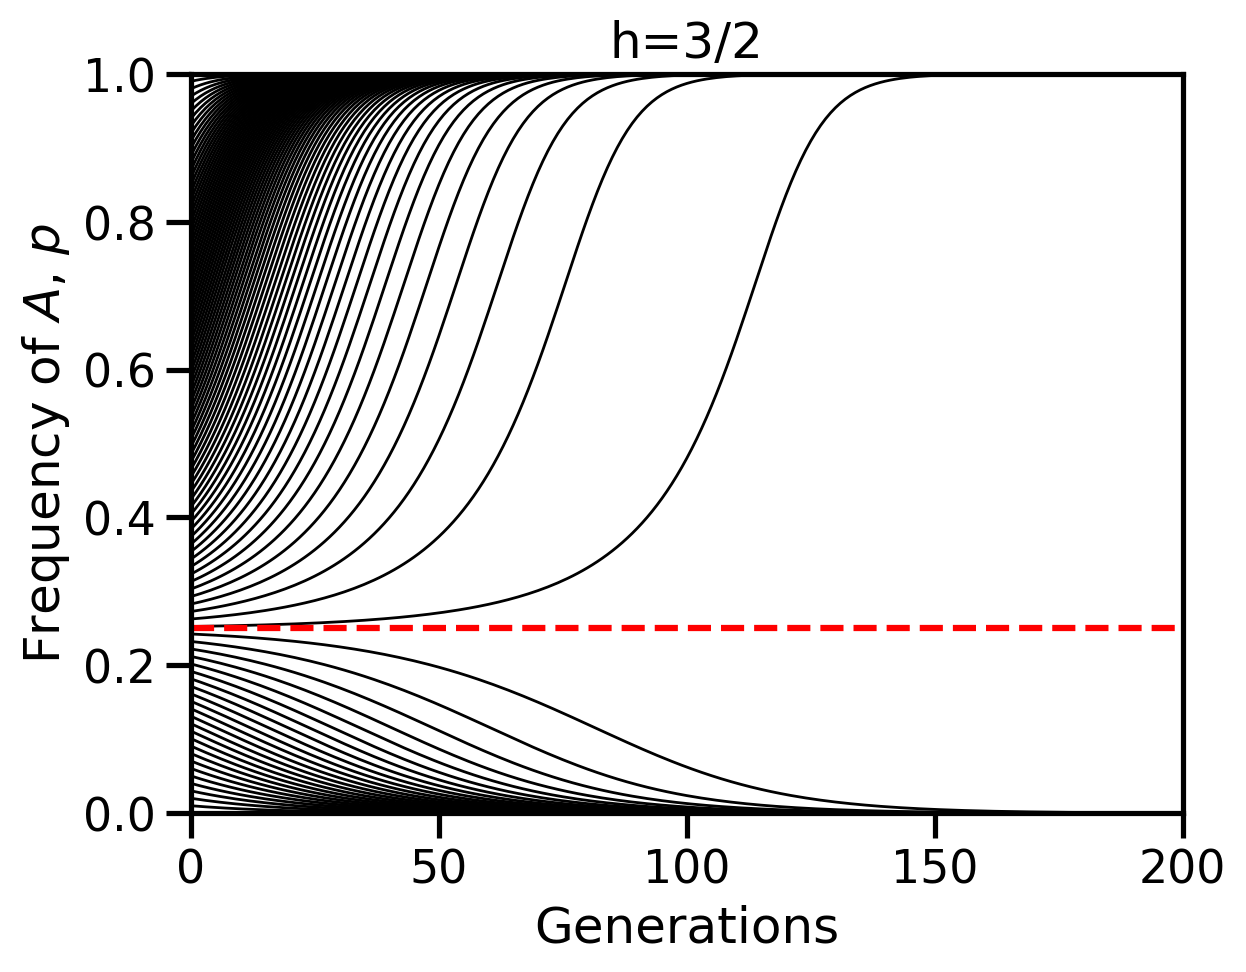

In [12]:
h = 3/2
for p0 in np.linspace(0, 1, 100):
    p = diploid_selection(p0, 0.1, h, 200)
    plt.plot(p, 'k', lw=1)

plt.axhline((h-1)/(2*h-1), ls='--', color='r')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0, 1)
plt.xlim(0, 200)
plt.title('h=3/2');

## Dominance

**Definition.**
*Overdominance* occurs when $h<0$. Also called *heterozygote advantage*.

*Incomplete dominance* occurs when $0<h<1$. Also called *partial dominance*, *semi-dominance* or *intermediate inheritance*.

*Underdominance* occurs when $h>1$. Also called *heterozygote inferiority*, *heterozygote disadvantage*, and *disruptive selection*.

**Conclusion.**

1. With overdominance ($h<0$), fixations of $A_1$ and $A_2$ are unstable and there is a protected polymorphism $p^*=\frac{h-1}{2h-1}$.

1. With incomplete dominance ($0 \le h \le 1$), fixation of $A_1$ is a stable and fixation of $A_2$ is unstable.

1. With underdominance ($h>1$), fixations of $A_1$ and $A_2$ are stable, and $p^*$ separates the domains of attraction of the fixations.

### Example: Sickle cell and malaria

Sickle cell anaemia:

- Abnormality in the oxygen-carrying protein haemoglobin found in red blood cells
- Leads to rigid, sickle-like shape under certain circumstances
- A number of health problems may develop
- Causing allele in chromosome 11
- Recessive disease ($h=0$)

In 2015
- 4.4 million with sickle cell disease ($A_2 A_2$)
- 43 million with sickle cell trait ($A_1 A_2$)
- Mainly in Sub-Saharan Africa, India, Arabia.
- 114,800 deaths

Malaria:

- The malaria parasite attacks red blood cells
- When attacking sickle cells, they rupture prematurely
- Parasite cannot reproduce
- In areas where malaria is a problem $A_1 A_2$ have increased survival
- Overdominance $h<0$

### Distributions of sickle cell anaemia and of malaria

Sickle cell anaemia

![inline](https://upload.wikimedia.org/wikipedia/commons/2/24/Sickle_cell_distribution.jpg)

Malaria

![inline](https://upload.wikimedia.org/wikipedia/commons/6/65/Malaria_distribution.jpg)

# Discrete-time univariate deterministic model: selection and mutation

Assume the favorable allele $A_1$ mutates to $A_2$ with probability $u \ll 1$.
We neglect back mutation from $A_2$ to $A_1$ (becuase $A_2$ is deleterious so it will remain at a low frequency, and thus the product of its frequency and the mutation probability $u$ will be very low and negligble.

So, allele frequencies after selection and mutation:

$$
p' = (1-u)\frac{p^2 + p q (1-hs)}{p^2 + 2 p q (1-hs) + q^2 (1-s)}
$$

In [13]:
def diploid_selection_mutation(p0, s, h, u, tmax):
    p = [p0]

    for t in range(1, tmax):
        p_ = p[t-1]
        q_ = 1-p_
        wbar  = p_*p_ + 2*p_*q_*(1 - h*s) + q_*q_*(1-s) # mean fitness
        p.append( 
            (1-u) * (p_*p_ + p_*q_*(1-h*s)) / wbar
        )

    return p

Start with a simple model for a recessive gene, $h=0$.
Set $p'=p$, we have
$$
p = (1-u)\frac{p^2 + p q}{\bar{w}} \Rightarrow $$$$
p^2 + 2 p (1-p) + (1-p)^2 (1-s) - (1-u)(p + 1 - p) = 0 \Rightarrow $$$$
p^2 + 2 p - 2p^2 + (1-2p+p^2) (1-s) - 1 + u = 0 \Rightarrow $$$$
p^2(1-2+1-s) + p(2-2+2s) +1 - s - 1 +u = 0 \Rightarrow $$$$
-s p^2 + 2s p - s +u = 0 \Rightarrow $$$$
s p^2 - 2s p + s -u = 0 \Rightarrow $$$$
p^* = \frac{2s \pm \sqrt{4s^2 - 4 s (s-u)}}{2s} = 
1 \pm \frac{\sqrt{4su}}{2s} = 
1 \pm \sqrt{\frac{u}{s}}
$$

**Result.** 
The polymorphic equilibrium frequency of a completely recessive allele is $q^*=\sqrt{\frac{u}{s}}$.

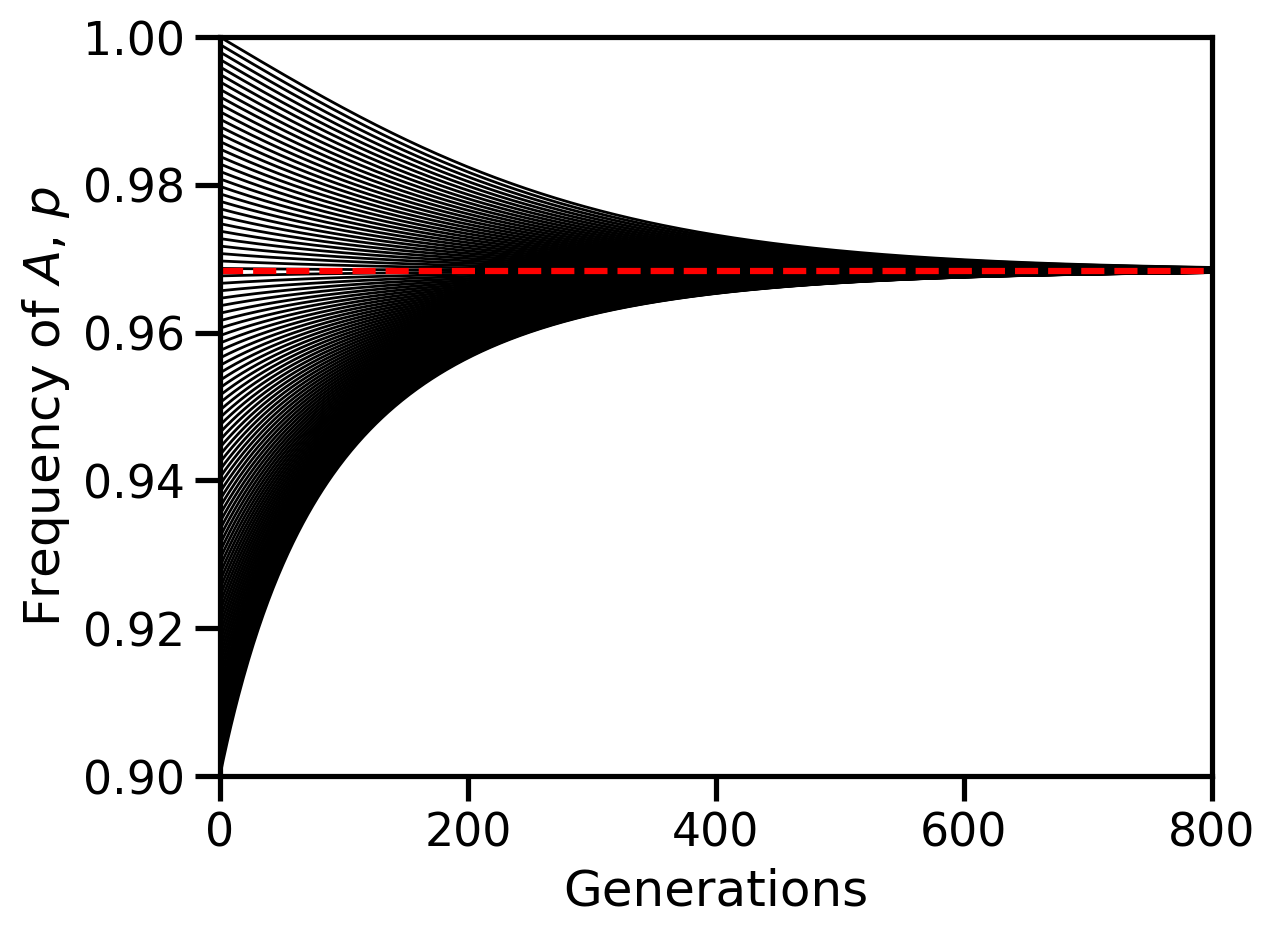

In [14]:
h = 0
u = 1e-4
s = 0.1
tmax = 800
for p0 in np.linspace(0.9, 1, 100):
    p = diploid_selection_mutation(p0, s, h, u, tmax)
    plt.plot(p, 'k', lw=1)

plt.axhline(1 - (u/s)**0.5, ls='--', color='r')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0.9, 1)
plt.xlim(0, tmax);

For parial dominance $h>0$, we first derive an expression for the change if the frequency of $A_1$ due to selection $\Delta_s p$.
$$
\bar{w} (p'-p) = p^2 + pq(1-hs) - p^3 -2p^2q(1-hs)-pq^2(1-s) = $$$$
p^2(1-p) + pq(1-hs) -2p^2q(1-hs)-pq^2(1-s) = $$$$
pq\big[p + 1 - hs -2p+2phs-q+qs \big] = $$$$
pq\big[p + 1 - hs -2p+2phs-1+p+s-sp \big] = $$$$
pq\big[-hs+2phs+s-sp\big] = $$$$
pqs\big[-h+ph+ph+1-p\big] = $$$$
pqs\big[-h(1-p)+ph+q\big] = $$$$
pqs\big[ph+q(1-h)\big] \Rightarrow $$$$
\Delta_s p = \frac{pqs(ph+q(1-h))}{\bar{w}}
$$

We now derive an expression for the change if the frequency of $A_1$ due to mutation $\Delta_u p$,
$$
p' = (1-u)p \Rightarrow $$$$
p'-p = -up = -u(1-q) = -u+uq
$$

and since $q \approx 0$ and $u \approx 0$, that is, both are very small, we disregard terms of the order of $qu$
$$
\Delta_u p = -u 
$$

To find a **mutation-selection balance** (this is a special name for the equilibrium between selection and mutation) we require $\Delta_s p + \Delta_u p = 0$
$$
\frac{pqs(ph+q(1-h))}{\bar{w}} - u = 0 \Rightarrow $$$$
pqs(ph+q(1-h)) = u \cdot \bar{w} \Rightarrow $$$$
pqs(ph+q(1-h)) = u \big[p^2 + 2pq(1-hs) +q^2(1-s) \big]
$$

Disregarding terms of the order of $q^2$ and $qu$,
$$
pqs(ph+q(1-h)) = u \big[p^2 + 2pq(1-hs) +q^2(1-s) \big] \Rightarrow $$$$
p^2qsh = u p^2 \Rightarrow $$$$
qsh = u
$$

**Result.**
The polymorphic equilibrium frequency of a partially recessive allele is $q^* \approx \frac{u}{sh}$.

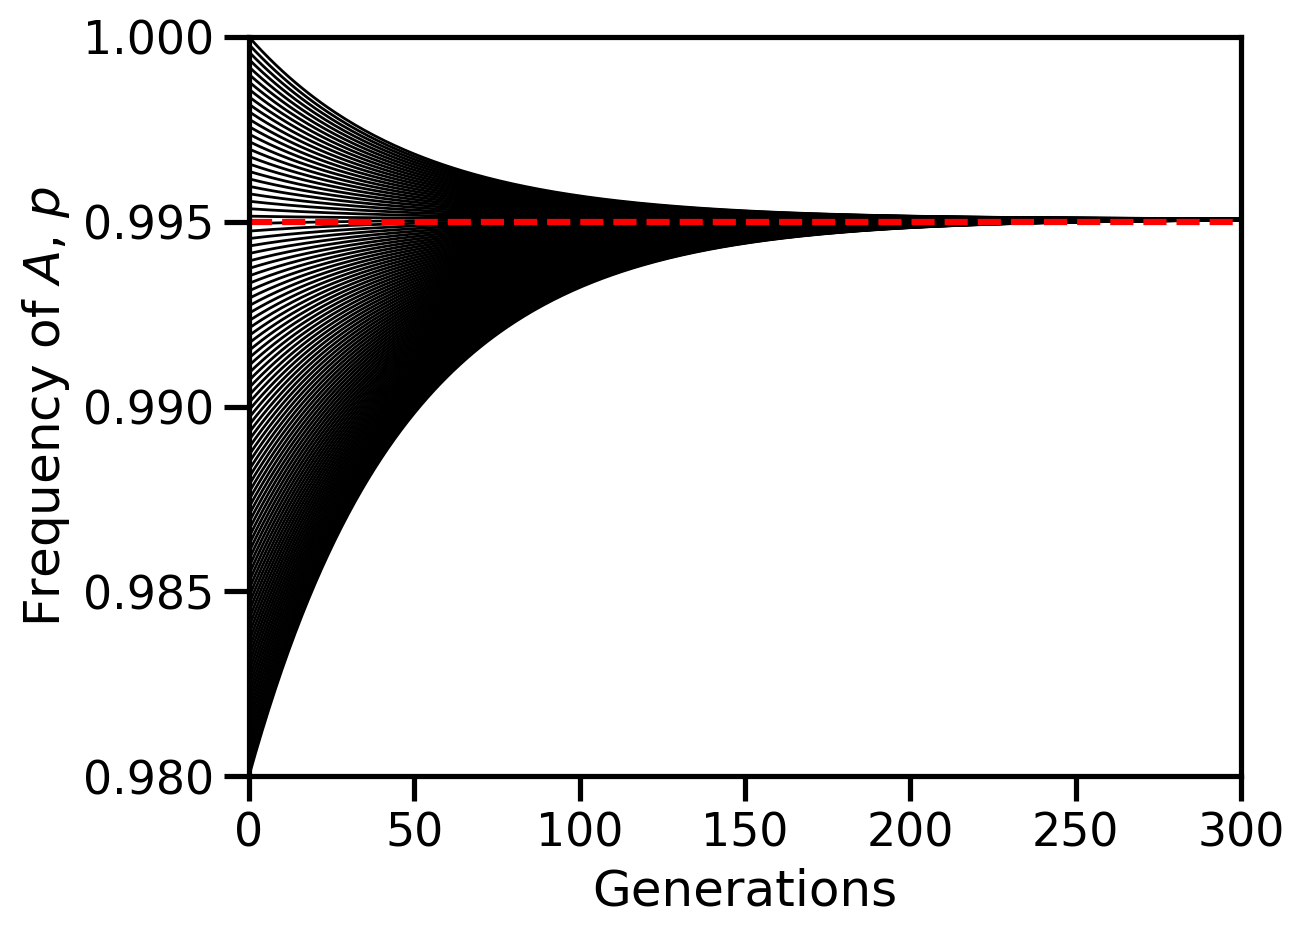

In [15]:
h = 0.2
u = 1e-4
s = 0.1
tmax = 300
for p0 in np.linspace(0.98, 1, 100):
    p = diploid_selection_mutation(p0, s, h, u, tmax)
    plt.plot(p, 'k', lw=1)

plt.axhline(1 - u/(s*h), ls='--', color='r')
plt.xlabel('Generations')
plt.ylabel('Frequency of $A$, $p$')
plt.ylim(0.98, 1)
plt.xlim(0, tmax);

# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com) and is part of the [Models in Population Biology](http://modelspopbiol.yoavram.com) course at Tel Aviv University.

This work is licensed under a CC BY-NC-SA 4.0 International License.